In [38]:
# 필요한 패키지 import
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.io.gfile import glob
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
import matplotlib.pyplot as plt
import random
import os

ModuleNotFoundError: No module named 'pillow'

In [34]:
# 글로벌 변수 선언
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH,IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # 컬러 사진이므로 채널이 3(rgb)

In [35]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = to_categorical(np.array(data['target']))#, 133)
    return dog_files, dog_targets
# load train, test, and validation datasets
train_files, train_targets = load_dataset('./dogs/train')
valid_files, valid_targets = load_dataset('./dogs/valid')
test_files, test_targets = load_dataset('./dogs/test')
# load list of dog names
# the [20:-1] portion simply removes the filepath and folder number
dog_names = [item[20:-1] for item in sorted(os.listdir("./dogs/train/"))]
# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


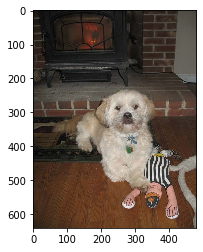

In [36]:
sample_folder = random.choice(foldernames)
sample_img = random.choice(os.listdir("./dogs/train/"+sample_folder))
random_img = load_img('./dogs/train/'+sample_folder+'/'+sample_img)
plt.imshow(random_img)

In [37]:
# define functions for reading in image files as tensors
def path_to_tensor(img_path, target_size=(224, 224)):
    # loads RGB image as PIL.Image.Image type
    # 299 is for xception, 224 for the other models
    img = image.load_img(img_path, target_size=target_size)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, (target_size,) 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths, target_size = (224, 224)):
    list_of_tensors = [path_to_tensor(img_path, target_size) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)
# run above functions
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

TypeError: 'module' object is not callable

In [12]:
# 신경망 모델 구성 (cnn)
# 언제나 그렇듯 그냥 잘 나올때까지 계속 바꿔보는것
# 이 밑은 일단 따라해보는 것이다
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='softmax')) # 고양이와 강아지니까 2

model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [ ]:
# 콜백 정의
# earlystopping? 일정 횟수만큼 정확도가 떨어질때 트리거를 걸어두고 일정 횟수 더 트레이닝을 돌렸더니 또 정확도가 떨어질때 트레이닝을 끝내는 함수
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
# 학습하는 동안 정확도를 감시하다가 어느 기준이 되면 학습율을 조정해주는 클래스
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5,min_lr=0.00001)

#콜백 설정
callbacks = [earlystop,learning_rate_reduction]